# Expectation - Maximization on a mixture of Markov models

In this notebook, the whole algorithm process is available. 

- Data importation
- Split train-test data
- Definition of all the needed functions
- The algorithm (e_m_mm function)
- If run with many k, plot the max likelihoods to choose the good one
- Cluster probabilities
- Visualizing the customer journeys in the different clusters
- Visualize the models
- Generate journeys
- Visualize the generated journeys


- 0: work/job
- 1: Eat meal outside of home
- 2: Working at home (for pay)
- 3: Recreation/Entertainment
- 4: Routine shopping
- 5: Service Private Vehicle
- 6: Attending class
- 7: Health Care
- 8: Civig/Religious Activities
- 9: Household errands
- 10: Activity
- 11: All other home activities
- 12: Visit Friends/Relatives
- 13: Picked up passenger
- 14: Shopping for major purchases
- 15: Personal Business

In [1]:
%matplotlib inline

import numpy as np
import calendar
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
from scipy import stats, optimize, misc
from collections import Counter
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive
import pickle
import pylab
import time 
from joblib import Parallel, delayed 

sns.set_style('whitegrid')
sns.set_context('notebook')

In [2]:
# chains = pd.read_pickle('../../Cplus_International/pickles/abonnes_chains_mapped_clean.pickle')
# cote_ivoire_reabo = pd.read_pickle('../../Cplus_International/pickles/cote_ivoire_clean.pickle')

In [3]:
with open ('Archive/chicago-simplified-with-prom-age-cleaned.csv.pickle', 'rb') as fp:
    itemlist = pickle.load(fp)
ch = []
maxx = []
for i in itemlist:
    c = []
    c.append(randint(100,99999))
    c.append(i)
    maxx.append(max(i))
    ch.append(c)
chains = itemlist
chains = pd.DataFrame(ch, columns=['ID_ABONNE', 0])
chains = chains.set_index('ID_ABONNE')

In [4]:
chains.head()

,0
ID_ABONNE,
2327,"[11, 3, 11, 3, 12, 11]"
35759,"[11, 4, 11]"
35834,"[11, 0, 11]"
18686,"[11, 0, 11]"
68773,"[11, 6, 11]"


In [5]:
SIZE = max(maxx)+1

In [6]:
def generate_initials_tm(k, size):
    list_tm = defaultdict(list)
    for i in range(0,k):
        list_tm[i] = np.random.dirichlet(np.ones(size),size=size)
    return list_tm

def generate_initials_fp(k, size):
    list_tm = defaultdict(list)
    for i in range(0,k):
        list_tm[i] = np.random.dirichlet(np.ones(size),size=1)[0]
    return list_tm

def generate_tms(K, size):
    tms = defaultdict(list)
    for k in range(0, K):
        tms[k] = generate_initials_tm(1, size)[0]
    return tms

def generate_fps(K, size):
    fps = defaultdict(list)
    for k in range(0, K):
        fps[k] = generate_initials_fp(1, size)[0]
    return fps


def generate_ps(K):
    ps = defaultdict(list)
    for k in range(0,K):
        ps[k] = 1/K
    return ps



### Test-train split

The data is splitted into a train and test set. We make the difference between the indexes and the sequences, in order to retrieve the customers id later, and to know who is in which cluster. 

In [7]:
from sklearn.model_selection import train_test_split
s_train, s_test = train_test_split(chains, test_size=0.2)

sequences_train = []
indexes_train = []

sequences_test = []
indexes_test = [] 

# Only add to sets if the length of the sequence is longer than 1, and if not none. 
for i,s in s_train.iterrows():
    if (s[0] != None) and (len(s[0]) > 1):
        sequences_train.append(s[0])
        indexes_train.append(s.name)
        
for i,s in s_test.iterrows():
    if (s[0] != None) and (len(s[0]) > 1):
        sequences_test.append(s[0])
        indexes_test.append(s.name)

## Functions definition for the E-M algorithm


In [8]:

def compute_transition_matrix(sequences):
    # Start with 1, not 0: Regularizes the probability vectors to avoid
    # problems with zeros; is also the estimate with flat, weak prior over
    # probability vectors from Bayesian approach.
    tm = np.ones((SIZE,SIZE))
    for seq in sequences:
        sq1 = seq[:-1]
        sq2 = seq[1:]
        z = Counter(zip(sq1, sq2))
        v = list(z.values())
        keys = list(zip(*z.keys()))
        tm[keys[0], keys[1]] += v
    tm = tm/tm.sum(axis=1, keepdims=True)
    return tm

def compute_first_event_probabily(sequences):
    f = [item[0] for item in sequences]
    f_probs = []
    p_f = pd.value_counts(f)/len(sequences)
    test_probs = np.zeros(SIZE)
    for i in range(0,SIZE):
        if i in p_f.index:
            idx = p_f.index.tolist().index(i)
            test_probs[i] = p_f.values[idx]

    return test_probs.tolist()

def compute_log_p_sequence(sequ, tm, fp):
    log_p = np.log(tm[sequ[:-1], sequ[1:]])
    return np.sum(log_p) + np.log(fp[sequ[0]])

def compute_log_p_sequences(sequences, tm, fp):
    log_probs = []
    for sequ in sequences:
        log_p = compute_log_p_sequence(sequ, tm, fp)
        log_probs.append(log_p)
    return log_probs
        
def log_likelihood(sequences, tms, fps, ps):
    logs = []
    for i in range(0,len(tms)):
        log = compute_log_p_sequences(sequences, tms[i], fps[i]) + np.log(ps[i])
        logs.append(log)
    log_p_x_given_c = misc.logsumexp(logs, axis=0)
    return np.sum(log_p_x_given_c)
    
def find_indexes_ptms(ptms):
    clusters = []
    indexes = defaultdict(list)
    for j in range(0,len(ptms[0])):
        mx = []
        for i in range(0, len(ptms)): 
            mx.append(ptms[i][j])
        clusters.append(mx.index(max(mx)))
    for i in range(0, len(clusters)):
        indexes[clusters[i]].append(i)
    return indexes

def expectation(sequences, tms, fps, ps):
    ptms_b = []
    for i in range(0, len(tms)):
        #tms_u = tms[i][0]
        #tms_u[tms_u == 0] = 0.00001
        ptm = np.exp(compute_log_p_sequences(sequences, tms[i], fps[i]))
        ptm = np.array(ptm) * ps[i]
        ptms_b.append(ptm)
        
    # Warning: this is using the Python sum, which means that we're
    # summing over axis=0, i.e. over clusters
    denominator = sum(ptms_b)
    
    ptms = ptms_b / denominator
    
    ixs = find_indexes_ptms(ptms)
    return ptms, ixs

def maximization(sequences, ptms, ixs):
    models = defaultdict(list)
    tms = defaultdict(list)
    fps = defaultdict(list)
    ps = defaultdict(list)
    for ix in ixs:
        for i in ixs[ix]:
            models[ix].append(sequences[i])
    
    for ix in ixs:
        ctm = compute_transition_matrix(models[ix])
        tms[ix] = ctm
        cfp = compute_first_event_probabily(models[ix])
        fps[ix] = cfp
        ps[ix] = (len(models[ix])/len(sequences))
    
    return tms,fps, ps


def maximization_soft(sequences, ptms,K):
    fps = np.ones((SIZE,K))

    Nk = ptms.sum(axis=1)
    for i,s in enumerate(sequences):
        first_state = s[0]
        fps[first_state, :] += ptms[:,i]
    fps = fps / Nk
    fps = {k: fps[:, k] for k in range(K)}
    
    tms = compute_transition_matrix_soft(sequences, ptms,K)
    
   
    ps = Nk / len(sequences)
    return tms, fps, ps

def compute_transition_matrix_soft(sequences, ptms,K):
    # Start with 1, not 0: Regularizes the probability vectors to avoid
    # problems with zeros; is also the estimate with flat, weak prior over
    # probability vectors from Bayesian approach.
    tm = np.ones((K, SIZE, SIZE))
    for seq_idx, seq in enumerate(sequences):
        sq1 = seq[:-1]
        sq2 = seq[1:]
        p_clusters_for_seq = ptms[:, seq_idx]
        n_transitions = len(sq1)
        for transition_idx in range(n_transitions):
            i = sq1[transition_idx]
            j = sq2[transition_idx]
            tm[:, i, j] += p_clusters_for_seq
            
    tm = tm / tm.sum(axis=-1)[:, :, None]
    tm = {k: tm[k, :, :] for k in range(K)}
        
    return tm



## The algorithm: E-M calling all the above functions

In [9]:
log_likelihoods = defaultdict(list)
param_k = defaultdict(list)
seq = sequences_train
max_lh_train = defaultdict(list)
max_lh_test = defaultdict(list)
max_lh = defaultdict(list)

def e_m_mm(k, log_likelihoods, param_k, seq,max_lh_test, max_lh_train, max_lh, prefix):
    print(k)
    lh_k = {}
    params_ki = defaultdict(list)
    for i in range(1):
        fps = generate_fps(k,SIZE)
        tms = generate_tms(k,SIZE)
        ps = generate_ps(k)
        maximized = False
        old_lh = 1
        log_likelihoods[k] = []
        while not maximized:
            print('--------------')
            ptms, ixs = expectation(seq, tms, fps, ps)
            tms, fps, ps = maximization_soft(seq, ptms,k)
            lh = log_likelihood(seq,tms,fps,ps)
            log_likelihoods[k].append(lh)
            diff_percentage = (old_lh - lh)/old_lh
            if diff_percentage < 0.01:
                lh_k[i] = lh
                maximized = True
                params_ki[i] = [lh, fps, tms, ps, ptms, ixs]

            else:
                old_lh = lh
    key_max = max(lh_k, key=lh_k.get)
    param_k[k] = params_ki[key_max]
#     [lh, fps, tms, ps, ptms, ixs] = params_k[k]
    pki = param_k[k]
    
    lh_test = log_likelihood(sequences_test,pki[2],pki[1],pki[3])
    
    lh_test_bic = log_likelihood(sequences_test,tms,fps,ps) - 0.5*(len(tms[0])**2+len(tms[0])+1)*k*np.log(len(sequences_test))
    lh_test_aic = lh_test - (len(tms[0])**2+len(tms[0])+1)*k
    
    max_lh_test[k] = [lh_test, lh_test_bic, lh_test_aic]
#     with open('pickles_k/'+prefix + str(k)+'.pickle', 'wb') as handle:
#                     pickle.dump([fps, tms, ps, ptms, ixs, log_likelihoods, lh_k, param_k,max_lh_test], handle, protocol=pickle.HIGHEST_PROTOCOL)
    return fps, tms, ps, ptms, ixs, log_likelihoods, lh_k, param_k,max_lh_test
    

# The algorithm is saving pickles in "pickles_k/", the prefix is usefull to separate different experiments.
prefix = 'TEST'

# Runing the algorithm with different ks. Here, 12 - 13 - 14. Thus, all the list belows have to be at size 3. 
# If only needed to run with a specific k (i.e. 13), than ks = [13] and all the others length = 1. 

ks = [3,4]
log_likelihoods = [defaultdict(list),defaultdict(list)]
param_k = [defaultdict(list),defaultdict(list)]
max_lh_train = [defaultdict(list),defaultdict(list)]
max_lh_test = [defaultdict(list),defaultdict(list)]
max_lh = [defaultdict(list),defaultdict(list)]
seq = [seq,seq]
prefixs = [prefix,prefix]

# We run it in parallel, with potentially all the processors of the computer. Better not compute more ks than the # of clusers of the computer. 

results = Parallel(n_jobs=-1, verbose=1, backend="multiprocessing")(map(delayed(e_m_mm), ks, log_likelihoods, param_k,seq,max_lh_test, max_lh_train, max_lh , prefixs))
# with open('pickles_k/'+prefix + "FINAL"+'.pickle', 'wb') as handle:
#                     pickle.dump([fps, tms, ps, ptms, ixs, log_likelihoods, lh_k, param_k,max_lh_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

3
--------------
4
--------------
--------------
--------------


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s finished


In [10]:
# with open('PICKLE_TO_WRITE', 'wb') as handle:
#                     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# with open(r"PICKLE_TO_READ", "rb") as input_file:
#     result2 = pickle.load(input_file)


## best K: if many K computed. 
### Optimizing the log-likelihood

- 0: without penalty
- 1: with BIC
- 2: with AIC

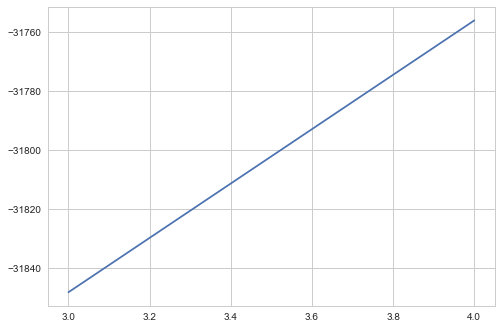

In [12]:
max_lh_test_list = []

without = 0
bic = 1
aic = 2
for i in range(0,len(results)):
    max_lh_test_list.append(results[i][8][ks[i]][without])

plt.plot(ks,max_lh_test_list)


## Probabilities of the clusters

Be carefull of the chosen k

In [13]:
# k = 10
# plt.bar(range(1,k),results[0][2])

## Classifying the users, retrieve the IDs in order to visualize them

In [14]:
# For "hard clustering" 
# A behavior can only be visualized once across all the different clusters. Each behavior is assigned to its most probable cluster

clusters_id = defaultdict(list)
# ixs = results[3][4]
ixs = results[0][4]
for i in range(0,len(ixs)):
    ixss = ixs[i]
    clusters_id[i] = [indexes_train[j] for j in ixss]

clusters_seq = defaultdict(list)
for i in range(0,len(ixs)):
    clusters_seq[i] = [sequences_train[i] for i in ixs[i]]
    

In [15]:
# with open('pickles_k/clusters_id.pickle', 'wb') as handle:
#     pickle.dump(clusters_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# # For soft clustering
# # A behavior can potentially be the most probable one in two cluster

# clusters_id = defaultdict(list)
# # ixs = results[3][4]
# ixs = results2[0][4]
# for i in range(0,len(ixs)):
#     clusters_id[i] = indexes_train

# clusters_seq = defaultdict(list)
# for i in range(0,len(ixs)):
#     clusters_seq[i] = sequences_train



## Compute the probabilities of the sequences under the model, and get the N most probable one and sort them. 

In [17]:
def compute_p_sequence_under_c(sequ, tm, fp):
    log_p = np.log(tm[sequ[:-1], sequ[1:]])
    return np.sum(log_p) + np.log(fp[sequ[0]])

def compute_p_sequences_under_c(sequences, tm, fp, ids):
    probs = []
    l = []
    for i in range(0,len(sequences)):
        sequ = sequences[i]
        log_p = compute_log_p_sequence(sequ, tm, fp)
        p = np.exp(log_p)
        probs.append([p**(1/len(sequ)),sequ, ids[i]])
    return probs

def get_n_best_seq_under_c(N, clusters_seq, clusters_id, tms, fps):
    best_n = defaultdict(list)
    for i in range(0, len(clusters_seq)):
        seqs = clusters_seq[i]
        ids = clusters_id[i]
        p_c_seq = compute_p_sequences_under_c(seqs, tms[i], fps[i], ids)
        p_c_seq.sort(key = lambda row: row[0], reverse=True)
        best_n[i] = [x[1] for x in p_c_seq[:N]]
    return best_n

def get_n_best_ids_under_c(N, clusters_seq, clusters_id, tms, fps):
    best_n = defaultdict(list)
    for i in range(0, len(clusters_seq)-1):
        print(i)
        seqs = clusters_seq[i]
        ids = clusters_id[i]
        p_c_seq = compute_p_sequences_under_c(seqs, tms[i], fps[i], ids)
        p_c_seq.sort(key = lambda row: row[0], reverse=True)
        best_n[i] = [x[2] for x in p_c_seq[:N]]
    return best_n
        

In [18]:
import pickle

pickle_out = open("results.pickle","wb")
pickle.dump(results, pickle_out)
pickle_out.close()

In [19]:
clusters_id_test = get_n_best_seq_under_c(10000, clusters_seq,clusters_id, results[1][1],results[1][0])

In [29]:
clusters_id_test[0]

[[11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 3, 11],
 [11, 

In [174]:
import pickle

pickle_out = open("clusters.pickle","wb")
pickle.dump(clusters_id_test, pickle_out)
pickle_out.close()

## Visualize the CJMs, by cluster and explore them. 

In [35]:
def date_is_valid(y,m,d):
    try:
        dt.datetime(y,m,d)
    except ValueError:
        return False
    return True


def compute_activation_date(expiration_date, resubscription_date=dt.datetime(1990,1,1), previous_expiration_date=dt.datetime(1990,1,1)):
    """ Compute the activation date of a subscription expiration date.

    Parameters
    ----------
    expiration_date : datetime
      The date of the expiration.
    resubscription_date : datetime
      The date of the resubscription.
    previous_expiration_date

    Returns
    -------
    activation_date : datetime
      The date of the activation date of the subscription
    """
    
    
    
    if expiration_date.month == 1:
        if expiration_date.day == 31:
            act_month = expiration_date.month
            act_year = expiration_date.year
            act_day = 1
        else:
            act_month = 12
            act_year = expiration_date.year -1
            act_day = expiration_date.day + 1
    elif expiration_date.day == 31:
        act_month = expiration_date.month
        act_year = expiration_date.year
        act_day = 1
    elif (expiration_date.month == 2) and (expiration_date.day >= 28):
        latest_date = resubscription_date
        if previous_expiration_date > latest_date: latest_date = previous_expiration_date
        if latest_date.month == 1 and latest_date.day > 28 and latest_date.year == expiration_date.year:
            act_month = expiration_date.month - 1
            act_year = expiration_date.year
            act_day = latest_date.day
        else:
            act_month = expiration_date.month - 1
            act_year = expiration_date.year
            act_day = expiration_date.day + 1
    else:
        act_month = expiration_date.month - 1
        act_year = expiration_date.year
        act_day = expiration_date.day + 1
    if not date_is_valid(act_year, act_month, act_day):
        last_day_of_month = calendar.monthrange(act_year, act_month)[1]
        act_day = last_day_of_month
    act_date = dt.datetime(act_year, act_month, act_day)
    return act_date

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20
       }



font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20
       }

plt.rc('font',**font) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=17) 
plt.rc('axes', linewidth=0)
pylab.rcParams['xtick.major.pad']='-35'

def plot_customer_journey(customer_id):
    RANGE_DATE = pd.date_range(pd.datetime(2014, 12, 1), pd.datetime(2016,12,30))
    i = 0
    dic_date = {}
    for d in RANGE_DATE:
        dic_date[d] = i
        i += 1
    single_behavior = cote_ivoire_reabo[cote_ivoire_reabo.ID_ABONNE == customer_id].sort_values(by="DATE_ECHEANCE")
    start_date = dt.datetime.date(compute_activation_date(single_behavior.iloc[0].DATE_ECHEANCE))
    end_date = dt.datetime.date(single_behavior.iloc[-1,2])
    date_range_tot = pd.date_range(start_date, end_date)
    x_axis_values = np.arange(1,len(date_range_tot)+1)
    x_axis = pd.Series(x_axis_values, date_range_tot)
    sd = dt.datetime.combine(start_date, dt.time.min)
    formules_uniques = ['ACCESS' ,'EVASION', 'LES CHAINES CANAL+','ACCESS & CANAL+', 'EVASION & CANAL+',"PRESTIGE",'TOUT CANAL' ]
    formules_uniques_bundle = {
        "ACCESS": "ACCESS",
        "EVASION": "EVASION",
        "LES CHAINES CANAL+": "CHAINES CANAL+",
        "ACCESS & CANAL+": "ACCESS & CANAL+",
        "EVASION & CANAL+":"EVASION & CANAL+",
        "PRESTIGE":"PRESTIGE",
        "TOUT CANAL":"TOUT CANAL",
    }
    formules = pd.Series(data=range(1,len(formules_uniques)+1),index=formules_uniques)
    single_behavior = single_behavior.reset_index()
    plt.figure(figsize=(20,10))
    shadow = []
    for i,l in single_behavior.iterrows():
        behavior = [np.nan]*len(x_axis)
#         behavior = [np.nan]*750
        date_echeance = l.DATE_ECHEANCE
        date_activation = compute_activation_date(date_echeance)
        formule = l.FORMULE
        if i < len(single_behavior)-1:
            formule_after = single_behavior.iloc[i+1].FORMULE
        delay_after = single_behavior.iloc[i-1].delay_int
        reabo = l.DATE_REABO 
        date_range = pd.date_range(date_activation, date_echeance)
        vertical_line = x_axis[date_echeance]
        first_index = x_axis[date_range[0]]
        if i>0:
            sh = np.arange(last_index , first_index)
            shadow.append(sh)
        for d in date_range:
            index = x_axis[d]
            behavior[index-1] = formules[formule]
        last_index = index
        if i == 0:
            plt.plot(x_axis+dic_date[sd], behavior,c="#4776AB", linewidth=7)
        elif delay_after >0:
            laters = plt.plot(x_axis+dic_date[sd], behavior, c="#CC7A72", linewidth=7)
        else:
            on_time = plt.plot(x_axis+dic_date[sd], behavior,c="#53ACCF", linewidth=7)
    plt.yticks(np.arange(1,8), np.vectorize(formules_uniques_bundle.get)(formules_uniques))
    month_days = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690,720,750,780]
    plt.xticks(month_days,np.arange(1,len(month_days)))
    plt.ylim(0, 8)
    plt.grid(b=False, axis="x")
    plt.xlabel('Months', size=20)
    plt.xlim(-10,745)
        
    for x in range(0,750,30):
        plt.axvline(x,ymin=0.1,ymax=0.9, linewidth=0.5, alpha=0.25, color="grey")
    for sh in shadow:
        plt.fill_between(sh+dic_date[sd],1, 7,facecolor="red",alpha=0.1)
    plt.savefig('cjm.png')
    
    plt.show()
    
def update_interact(cluster):
#     cluster_dic = {
#         "Cluster 1": 3,
#         "Cluster 2": 0,
#         "Cluster 3": 1,
#         "Cluster 4": 2,
#         "Cluster 5": 4
#     }
    
#     tasters = [50532744302, 50530751903, 50531753703,50531796303, 50532438203, 50532891104, 50530792402 ]
#     regular_high_spenders = [50530724603, 50530731903,50530733803, 50530772503, 50530817803, 50530838702, 50530847903]
#     regular_mainstream_subs = [50530731502, 50530742903, 50530806502, 50530811403, 50530812703,50530815305, 50530842402 ]
#     late_intermittens = [50537642902,50540591001, 50530779602, 50531005503, 50531067703, 50531210103, 50531220003, 50531341702, 50531432802 ]
    
    if cluster == "Cluster 1":
        abonnes_list = clusters_id_test[0][:200]
    elif cluster == "Cluster 2":
        abonnes_list = clusters_id_test[1][::200]
    elif cluster == "Cluster 3":
        abonnes_list = clusters_id_test[2][::200]
    elif cluster == "Cluster 4":
        abonnes_list = clusters_id_test[3][::200]
    elif cluster == "Cluster 5":
        abonnes_list = clusters_id_test[4][::200]
    elif cluster == "Cluster 6":
        abonnes_list = clusters_id_test[5][::200]
    elif cluster == "Cluster 7":
        abonnes_list = clusters_id_test[6][::200]
    elif cluster == "Cluster 8":
        abonnes_list = clusters_id_test[7][::200]
    elif cluster == "Cluster 9":
        abonnes_list = clusters_id_test[8][::200]
    elif cluster == "Cluster 10":
        abonnes_list = clusters_id_test[9][::200]
    elif cluster == "Cluster 11":
        abonnes_list = clusters_id_test[10][::200]
    elif cluster == "Cluster 12":
        abonnes_list = clusters_id_test[11][::200]
    elif cluster == "Cluster 13":
        abonnes_list = clusters_id_test[12][:200]

    dropdown_abonnes.options = abonnes_list

dropdown_abonnes = widgets.Dropdown(
)
    

cluster_choosing = widgets.ToggleButtons(
    options=["Cluster 1","Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11", "Cluster 12","Cluster 13"],
    value="Cluster 1",
    # rows=10,
    description='Cluster:',
    disabled=False
)
cluster_widget = interactive(update_interact, cluster =cluster_choosing )
cjm_widget = interactive(plot_customer_journey, customer_id = dropdown_abonnes )
display(cluster_widget)
display(cjm_widget)

## Visualize the different Markov models

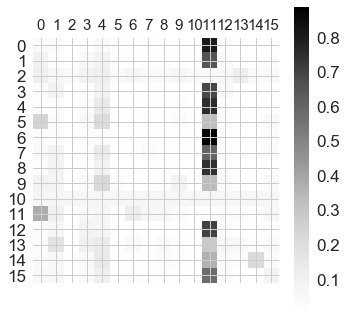

In [170]:
def plot_matrix(tm):
    pylab.rcParams['xtick.major.pad']='5'
#     plt.figure(figsize=(20,10))
    plt.matshow(tm[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],:][:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
    
    plt.yticks(np.arange(16))
    plt.xticks(np.arange(16))
    plt.colorbar()
    
k = 2

plot_matrix(results[0][1][k])

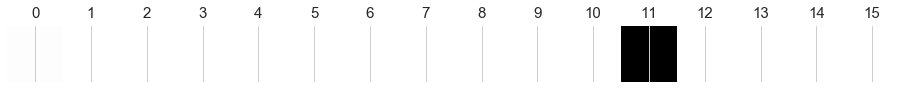

In [83]:
def plot_fp(fp):
    plt.matshow(fp[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]][None,:])
    plt.yticks([],[])    # both major and minor ticks are affecte
    plt.xticks(np.arange(16))

k = 2
plot_fp(results[0][0][k])

## Generate journeys based on the models, and visualize them

In [62]:
def generate_journey(tm, fp):
    journey = []
    idx = np.random.multinomial(1,fp-0.004).tolist().index(1)
    journey.append(idx)
    for i in range(0, randint(4,15)):
        last_event = journey[-1]
        next_event = np.random.multinomial(1,tm[last_event]).tolist().index(1)
        journey.append(next_event)
    return journey

def generate_journeys_random(tms, fps, ps, N):
    journeys = []
    for i in range(0,len(tms)):
        for j in range(0, int(ps[i]*N)):
            j = generate_journey(tms[i], fps[i])
            journeys.append(j)
    return journeys
      

In [107]:
sequence_to_plot = generate_journey(results[0][1][2],results[0][0][2])
sequence_to_plot

[11, 9, 0, 11, 0, 11, 7, 1, 0, 4, 11, 7, 11]

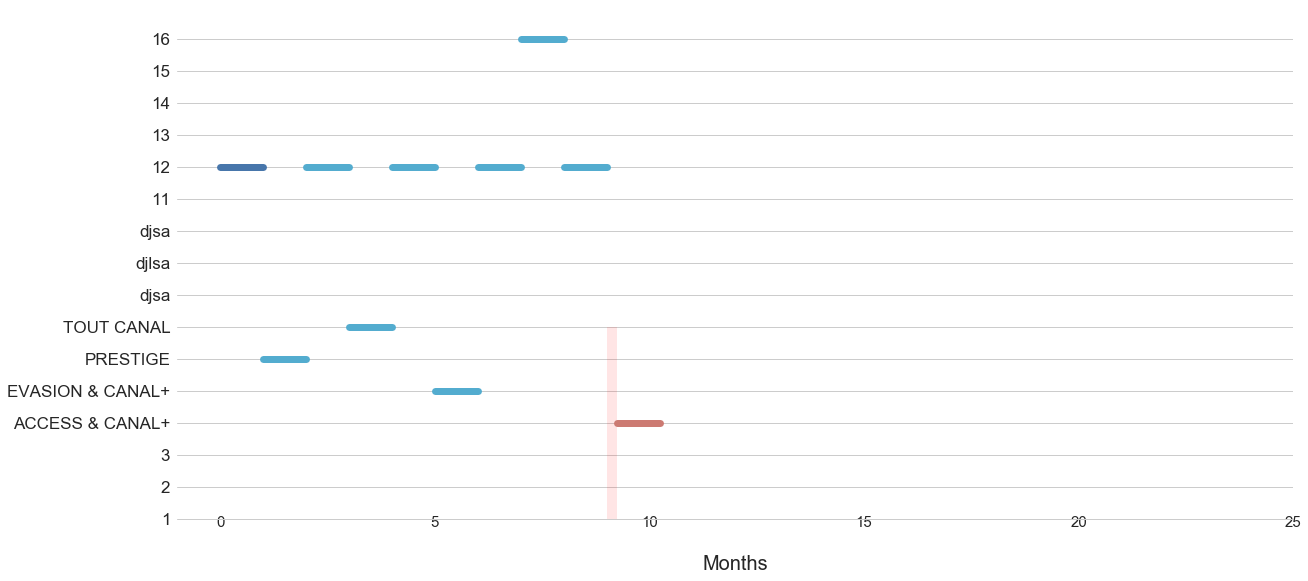

In [55]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20
       }



font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20
       }

plt.rc('font',**font) 
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=17) 
plt.rc('axes', linewidth=0)
pylab.rcParams['xtick.major.pad']='-35'

unique_events_dic = {
    'EVASION & CANAL+': 0,
    'TOUT CANAL': 1,
    'EVASION': 2,
    'PRESTIGE': 3,
    'ACCESS & CANAL+': 4,
    'ACCESS': 5,
    'LES CHAINES CANAL+': 6,
    '1-3': 7,
    '4-9': 8,
    '10+': 9
}


def plot_customer_journey_seq(sequence):

    formules_uniques = ['ACCESS' ,'EVASION', 'LES CHAINES CANAL+','ACCESS & CANAL+', 'EVASION & CANAL+',"PRESTIGE",'TOUT CANAL' ]
    formules_uniques_bundle = {
        5: 1,
        2: 2,
        6: 3,
        4: 4,
        0: 5,
        3: 6,
        1: 7,
        7: 8,
        8: 9,
        9: 10,
        10:11,
        11:12,
        12:13,
        13:14,
        14:15,
        15:16,
        16:17
    }
    
    
    formules_code = {
        1 : '1',
        2 : '2',
        3 : '3',
        4 : 'ACCESS & CANAL+',
        5 : 'EVASION & CANAL+',
        6 : 'PRESTIGE',
        7 : 'TOUT CANAL',
        8 : 'djsa',
        9 : 'djlsa',
        10: 'djsa',
        11: '11',
        12: '12',
        13:'13',
        14:'14',
        15:'15',
        16:'16'
        
    }
    plt.figure(figsize=(20,10))
    m = 0
    i = 0
    for s in sequence:
        i = i +1
        y = formules_uniques_bundle[s]
        if m == 0:
            plt.plot([m, m+1],[y,y], c="#4776AB", linewidth=7 )
            m = m + 1
            late = False
        else:
            if i == len(sequence):
                break;
            if y == 8:
                plt.fill_between([m,m+0.1],1, 7,facecolor="red",alpha=0.1)
                m = m + 0.1
                late = True
            elif y == 9:
                plt.fill_between([m,m+0.25],1, 7,facecolor="red",alpha=0.1)
                m = m + 0.25
                late = True
            elif y == 10:
                delay = randint(0,4) + 0.5
                plt.fill_between([m,m+delay],1, 7,facecolor="red",alpha=0.1)
                m = m + delay
                late = True
            else:
                if late:
                    plt.plot([m, m+1],[y,y], c="#CC7A72", linewidth=7 )
                    late = False
                    m = m+1
                else: 
                    plt.plot([m, m+1],[y,y], c="#53ACCF", linewidth=7 )
                    late = False
                    m = m+1
    plt.yticks(np.arange(1,17), np.vectorize(formules_code.get)(np.arange(1,17)))
    plt.ylim(0, 17)
    plt.grid(b=False, axis="x")
    plt.xlabel('Months', size=20)
    plt.xlim(-1,25)

    plt.show()

plot_customer_journey_seq(sequence_to_plot)

## Prepare file in order to benchmark the segmentation, if needed.

In [23]:

# fpiet = []
# for c in clusters_id:
#     for i in clusters_id[c]:
#         fpiet.append([i,c])
# file_pietro = pd.DataFrame(fpiet, columns=['ID_ABONNE','Cluster'])

In [24]:
# file_pietro.to_pickle('../../Cplus_International/pickles/EM_Bench.pickle')

In [25]:
# def sequences_probabilities(sequences, tm, fp, p):
#     ptms_b = []
#     #tms_u = tms[i][0]
#     #tms_u[tms_u == 0] = 0.00001
#     ptm = np.exp(compute_log_p_sequences(sequences, tm, fp))
#     ptm = np.array(ptm) * p
#     ptms_b.append(ptm)
#     print(ptms_b)
#     # Warning: this is using the Python sum, which means that we're
#     # summing over axis=0, i.e. over clusters
#     denominator = sum(ptms_b)

#     ptms = ptms_b / denominator

#     return ptms